<a href="https://colab.research.google.com/github/Anshuman22coder/ML-projects/blob/main/MALCIOUS_LINK_PREDICTION_NLP_Random_forest_96_accuarcy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

In [17]:
df=pd.read_csv("/content/malicious_phish.csv")
print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [18]:
df.type.value_counts()

,count
type,
benign,428103
defacement,96457
phishing,94111
malware,32520


In [28]:
#plotting wordcloud
df_phish=df[df.type=="phishing"]
df_malware=df[df.type=="malware"]
df_deface=df[df.type=="defacement"]
df_benign=df[df.type=="benign"]
print(df_phish)

                                                      url      type
0                                        br-icloud.com.br  phishing
21             signin.eby.de.zukruygxctzmmqi.civpro.co.za  phishing
28      http://www.marketingbyinternet.com/mo/e56508df...  phishing
40      https://docs.google.com/spreadsheet/viewform?f...  phishing
72                                   retajconsultancy.com  phishing
...                                                   ...       ...
651186            xbox360.ign.com/objects/850/850402.html  phishing
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/  phishing
651188         www.gamespot.com/xbox360/action/deadspace/  phishing
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)  phishing
651190          www.angelfire.com/goth/devilmaycrytonite/  phishing

[94111 rows x 2 columns]


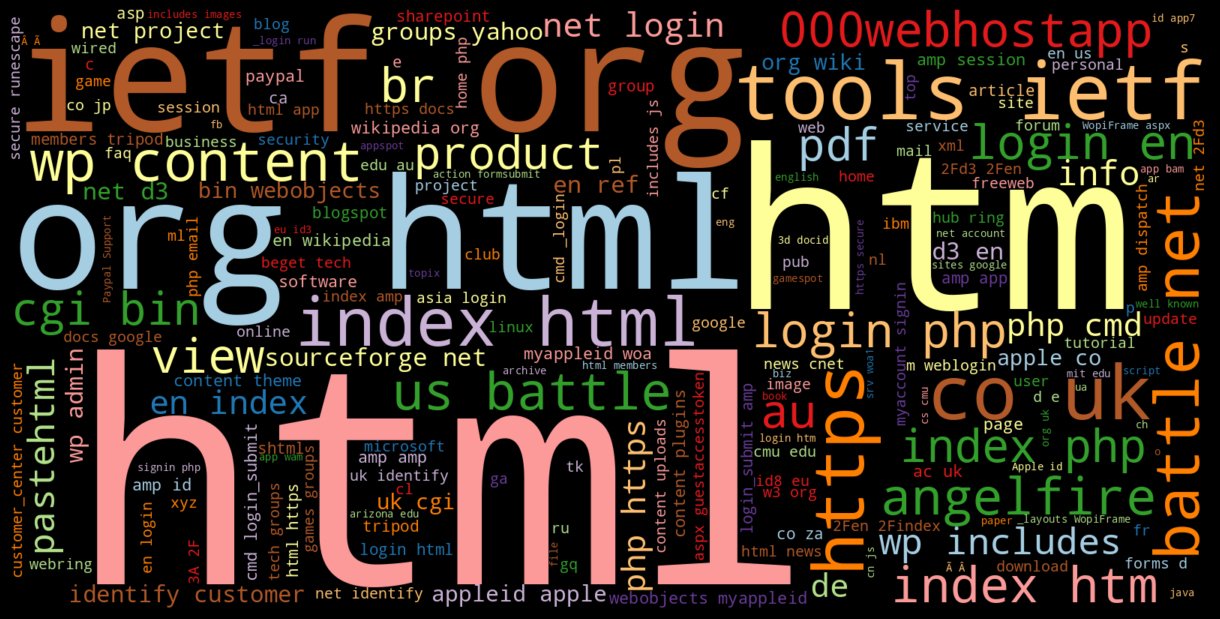

In [23]:
phish_url=" ".join(i for i in df_phish.url)  # this is a lazy evaluation technique that produces urls on the fly and the join() catches it but still do not joins it ,, only at the last this will be joined ..
wordcloud=WordCloud(width=1600,height=800,colormap="Paired").generate(phish_url)
plt.figure(figsize=(12,14),facecolor="k")
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

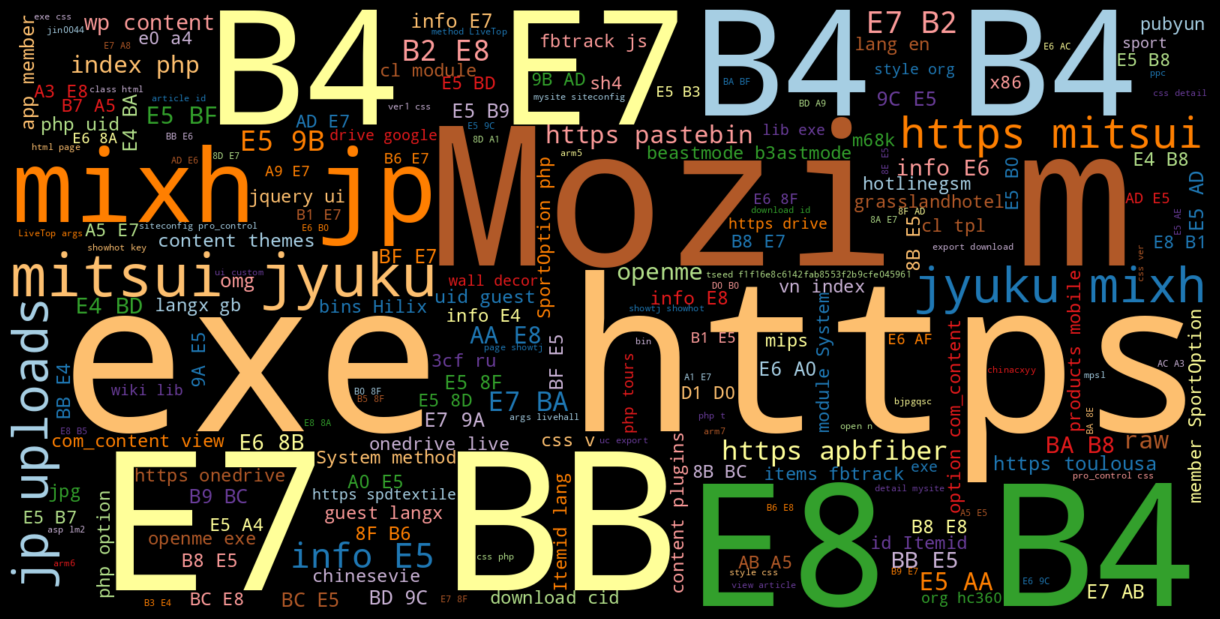

In [26]:
phish_url=" ".join(i for i in df_malware.url)  # this is a lazy evaluation technique that produces urls on the fly and the join() catches it but still do not joins it ,, only at the last this will be joined ..
wordcloud=WordCloud(width=1600,height=800,colormap="Paired").generate(phish_url)
plt.figure(figsize=(12,14),facecolor="k")
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

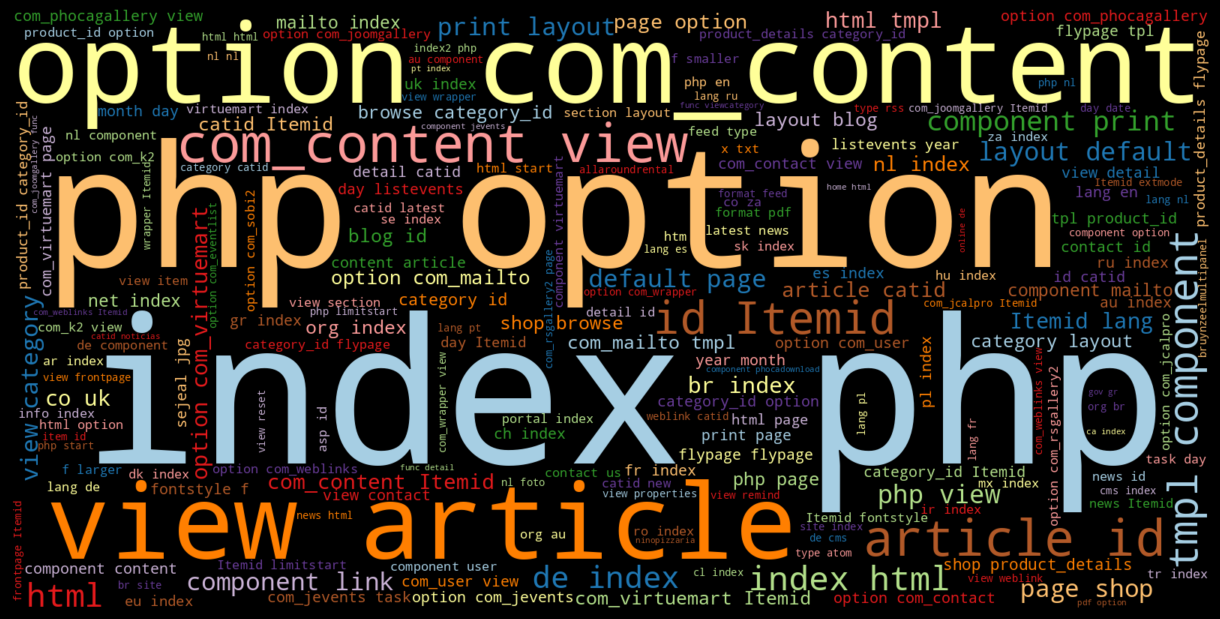

In [27]:
phish_url=" ".join(i for i in df_deface.url)  # this is a lazy evaluation technique that produces urls on the fly and the join() catches it but still do not joins it ,, only at the last this will be joined ..
wordcloud=WordCloud(width=1600,height=800,colormap="Paired").generate(phish_url)
plt.figure(figsize=(12,14),facecolor="k")
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

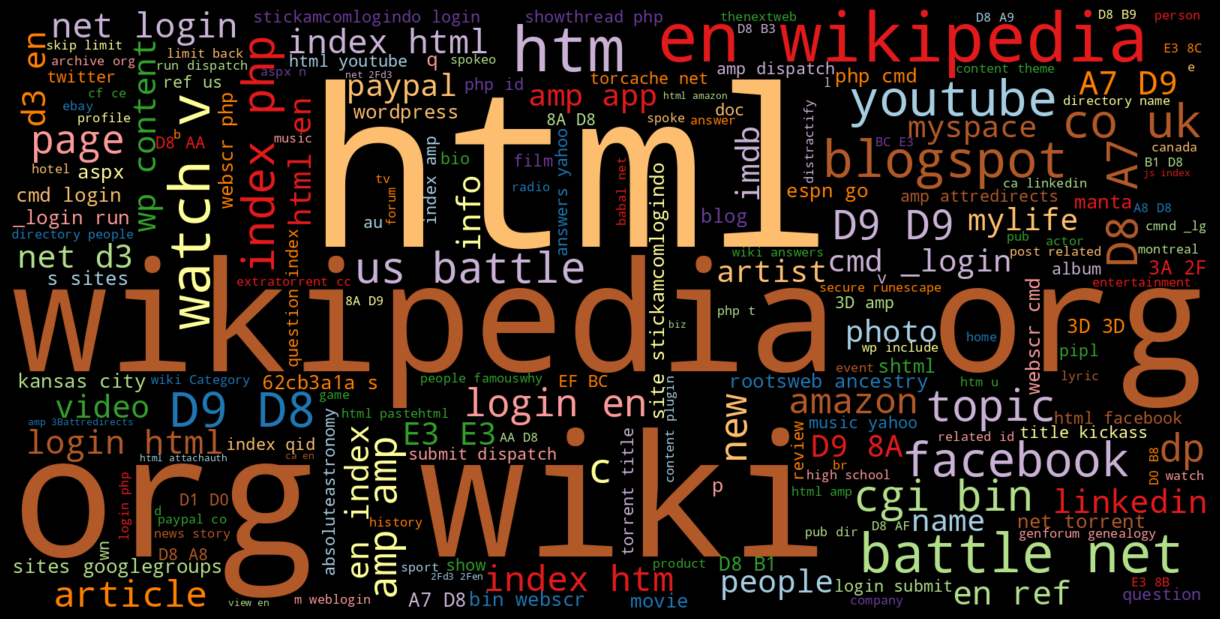

In [29]:
phish_url=" ".join(i for i in df_benign.url)  # this is a lazy evaluation technique that produces urls on the fly and the join() catches it but still do not joins it ,, only at the last this will be joined ..
wordcloud=WordCloud(width=1600,height=800,colormap="Paired").generate(phish_url)
plt.figure(figsize=(12,14),facecolor="k")
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [31]:
#feature engineering
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

from urllib.parse import urlparse


# abnoramal urll...finding
def abnormal_url(url):
  #.hostname is a way to extract netloc ...Parsed URL: ParseResult(scheme='https', netloc='www.example.com', path='/path/to/resource', params='', query='query=123', fragment='section')

    hostname = urlparse(url).hostname   # hostname in the url http:/www.google.com is www.google.com
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

#pip install googlesearch-python
###finding a site is google indexed or not

from googlesearch import search

def google_index(url):
    site = search(url,5)  # 5 defines for how many reslts we want..
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

def count_dot(url):
    count_dot = url.count('.') # maliciuos url likely contain multiple "."'s
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))

def count_www(url):    # maliciuos url likely contain multiple "www"'s
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):

    return url.count('@')   # maliciuos url likely contain multiple "@"'s

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))


def shortening_service(url):  # malicious urls may contain shortened services like bitly etc ,, for this we featured engineered this ..
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))


#Length of URL
df['url_length'] = df['url'].apply(lambda i: url_length(i))

#Hostname Length   # Parsed URL: ParseResult(scheme='https', netloc='www.example.com', path='/path/to/resource', params='', query='query=123', fragment='section')


def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df['count-letters']= df['url'].apply(lambda i: letter_count(i))

!pip install tld

from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 4.4 MB/s eta 0:00:00


EDA  Exploratory data analysis

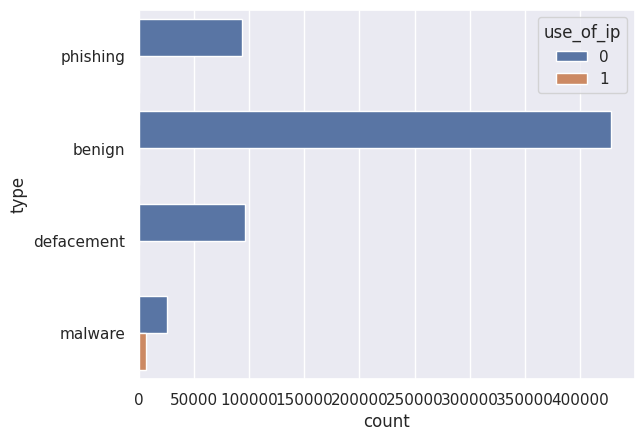

In [32]:
##1. Distribution of use_of_ip
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="use_of_ip")

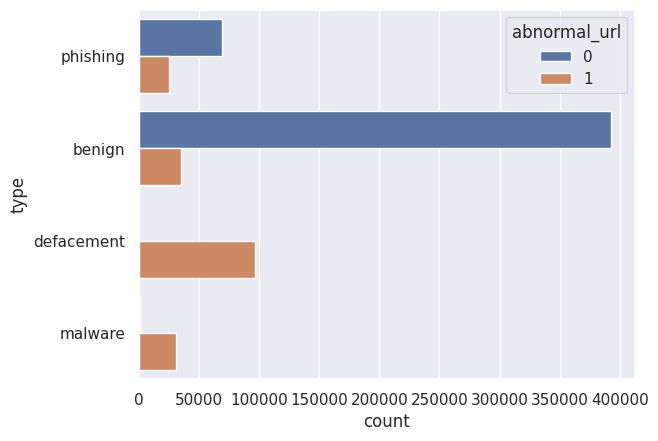

In [33]:
#2. Distribution of abnormal url
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="abnormal_url")

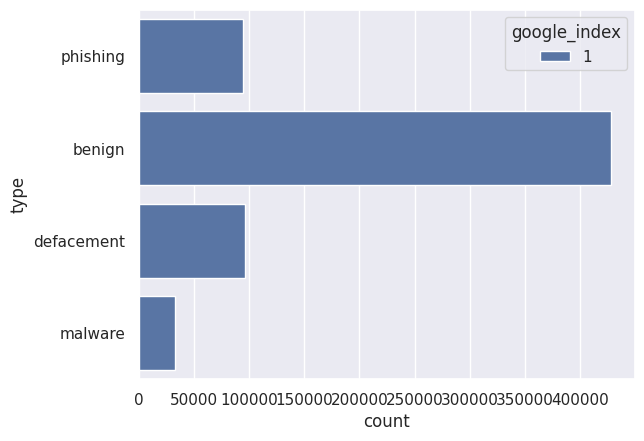

In [34]:
##3. Distribution of Google Index
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="google_index")

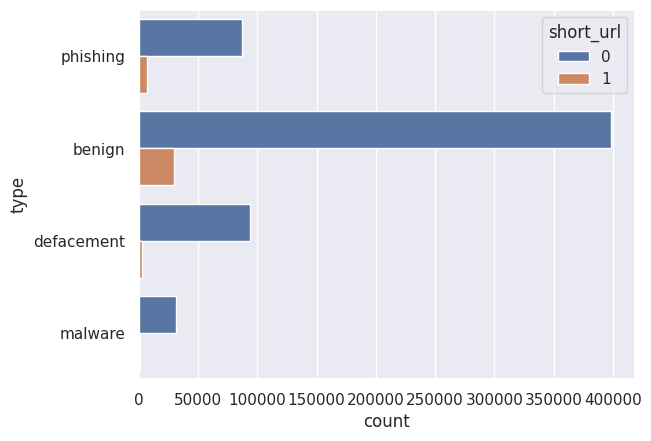

In [35]:
##4. Distribution of Shorl URL
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="short_url")

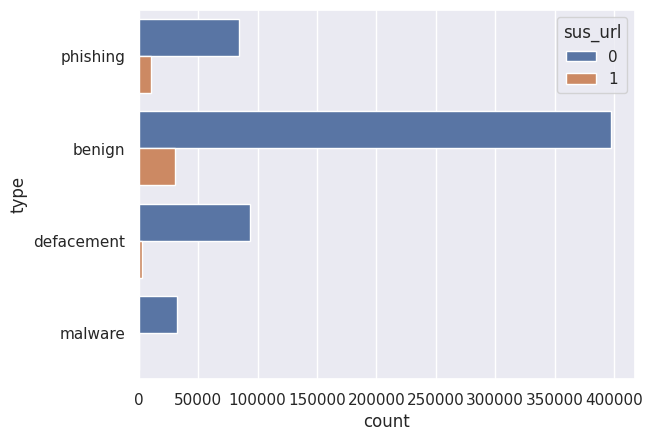

In [36]:
##5. Distribution of Suspicious URL
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="sus_url")

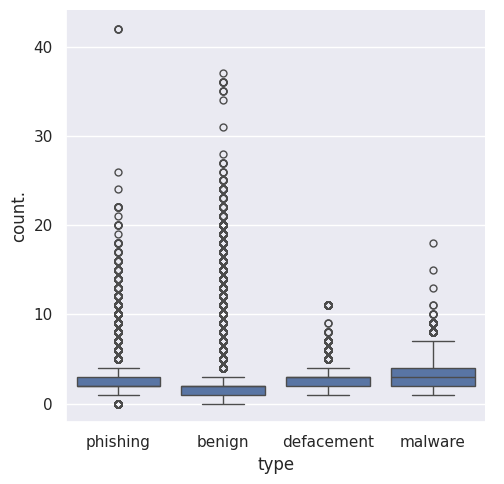

In [37]:
##6. Distribution of count of [.] dot
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count.", kind="box", data=df)

**Target Encoding***

In [40]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
df["type_code"]=lb.fit_transform(df["type"])
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count=,url_length,hostname_length,sus_url,count-digits,count-letters,fd_length,tld,tld_length,type_code
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,16,0,0,0,13,0,None,-1,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,35,0,0,1,29,5,None,-1,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,31,0,0,1,25,7,None,-1,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,4,88,21,0,7,63,9,be,2,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,3,235,23,0,22,199,9,net,3,1


In [41]:
## creation of features and target
# filter out google index as it has only 1 value
#independent variales or predictor variables ..
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]
##target variable
Y=df["type_code"]

In [42]:
X.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,2,0,0,2,0,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,2,0,0,3,0,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,3,1,0,1,0,0,0,1,...,1,1,4,88,21,0,9,2,7,63
4,0,1,2,0,0,1,0,0,0,1,...,1,1,3,235,23,0,9,3,22,199


In [44]:
# train test split
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=5,shuffle=True) # stratify =Y signifies that the split remains balanced between differnet classes in multiclass classification ,, Used in cases where one class has more data than othere..

In [57]:
X_train.shape

(520952, 21)

Model Building\1. Random Forest Classifier

In [45]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=100,max_features="sqrt")
rf.fit(X_train,Y_train)
y_pred_rf=rf.predict(X_test)

from sklearn import metrics
score =metrics.accuracy_score(Y_test, y_pred_rf)
print("Accuracy::%0.3f"%score)

Accuracy::0.966


In [47]:
cm = confusion_matrix(Y_test, y_pred_rf)
print(cm)

[[84336     9     6  1270]
 [   29 19147    14   102]
 [   33    57  6147   267]
 [ 2230   315    63 16214]]


In [49]:
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'],
                     columns = ['benign', 'defacement','phishing','malware'])
print(cm_df)

            benign  defacement  phishing  malware
benign       84336           9         6     1270
defacement      29       19147        14      102
phishing        33          57      6147      267
malware       2230         315        63    16214


In [50]:
##Prediction##
def main(url):

    status = []

    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))

    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))

    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))

    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)

    status.append(tld_length(tld))




    return status

In [55]:
def get_prediction_from_url(test_url):
    features_test = main(test_url)

    features_test = np.array(features_test).reshape((1, -1))

    print(features_test.shape)

    pred = rf.predict(features_test)
    if int(pred[0]) == 0:

        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:

        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res

    elif int(pred[0]) == 3.0:

        res="MALWARE"
        return res


In [56]:
urls = ['titaniumcorporate.co.za','en.wikipedia.org/wiki/North_Dakota']
for url in urls:
     print(get_prediction_from_url(url))

(1, 21)
MALWARE
(1, 21)
SAFE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
